## MOCAP

In [1]:
import os,pickle,time,sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib
from model import  BeatGAN_MOCAP
from metric import evaluate
from preprocess import *

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('-m', type=str, default='train',help="mode: /train/eval ")
args = parser.parse_args([])

In [3]:
device = torch.device("cuda:0" if
torch.cuda.is_available() else "cpu")

In [4]:
DATA_DIR="./dataset"
WALK=["35_01","35_02","35_03","35_04","35_05","35_06","35_07","35_08","35_09","35_10",
      "35_11","35_12","35_13","35_14","35_15","35_16"]
RUN=["35_17","35_18","35_19","35_20","35_21","35_22","35_23","35_24","35_25","35_26"]

WINDOW=64
STRIDE_TRAIN=5
STRIDE_TEST=20

#### Data load

In [5]:
file_path = os.path.join(DATA_DIR,"run",RUN[0]+".amc.4d")
timeseries=[]
with open(file_path,"r") as f:
    for line in f.readlines():
        x=line.strip().split(" ")
        timeseries.append([float(xx) for xx in x])
timeseries=np.array(timeseries)
timeseries.shape

(167, 4)

In [6]:
timeseries[:3]

array([[-50.8669, -35.5338, -29.5284, -22.223 ],
       [-53.0475, -35.2084, -31.855 , -20.266 ],
       [-54.4331, -33.8886, -34.2087, -18.2293]])

- [-1, 1] 사이 값으로 normalize

In [7]:
#[-1, 1] 사이 값으로 normalize
def normalize(seq):
    return 2*(seq-np.min(seq))/(np.max(seq)-np.min(seq))-1

for i in range(timeseries.shape[1]):
    timeseries[:,i]=normalize(timeseries[:,i])
timeseries[:3]

array([[-0.0332769 ,  0.69076852, -0.51227753, -0.31780669],
       [-0.13120349,  0.70733595, -0.58844549, -0.2480562 ],
       [-0.19342815,  0.77453229, -0.66550065, -0.17546508]])

In [8]:
timeseries.shape

(167, 4)

In [9]:
# STRIDE_TRAIN=5
train = get_from_one(file_path, train = True)
train.shape

(21, 64, 4)

In [10]:
train[0][:6]

array([[-0.0332769 ,  0.69076852, -0.51227753, -0.31780669],
       [-0.13120349,  0.70733595, -0.58844549, -0.2480562 ],
       [-0.19342815,  0.77453229, -0.66550065, -0.17546508],
       [-0.27507556,  0.77147236, -0.74229391, -0.0999264 ],
       [-0.38572461,  0.74135161, -0.81612439, -0.02303691],
       [-0.40598266,  0.8213732 , -0.87361539,  0.04950788]])

In [11]:
train[1][:6]

array([[-0.40598266,  0.8213732 , -0.87361539,  0.04950788],
       [-0.44035531,  0.86610627, -0.92271567,  0.11957914],
       [-0.38955528,  0.99571813, -0.94715778,  0.19542969],
       [-0.54936522,  0.90018813, -0.96680051,  0.26340701],
       [-0.61952065,  0.89553458, -0.98602747,  0.32369646],
       [-0.66805283,  0.89178731, -0.99681133,  0.37846823]])

In [12]:
# STRIDE_TEST=20
test = get_from_one(file_path, train = False)
test.shape

(6, 64, 4)

In [13]:
ts1,ts2=load_for_pic(ts_type="jump")
print(ts1.shape, ts2.shape)

(4, 443) (4, 150)


In [14]:
# WALK, RUN, OTHER의 data shape
stat_data()

6616
8224
10309


In [15]:
# train, test dataloader shape
# batch size = 64
dataloader = load_data()

(980, 4, 64)
(749, 4, 64)


#### Model load

In [16]:
from model import  BeatGAN_MOCAP

model=BeatGAN_MOCAP(dataloader,device)

/home/sunwookim/codes/TSAD_practice/BeatGAN/experiments/mocap/model.py:42: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(mod.weight)


- Model 구조 : Generator, Discriminator로 이루어짐

<p align="center">
    <img src="./imgs/BEATGAN.png" width = "40%" height = "40%">
</p>

In [17]:
class Generator(nn.Module):
    def __init__(self, nc):
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(
            # input is (nc) x 64
            nn.Linear(nc * 64, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, 10),

        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.Tanh(),
            nn.Linear(32, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, nc * 64),
            nn.Tanh(),
        )

    def forward(self, input):
        input=input.view(input.shape[0],-1)
        z = self.encoder(input)
        output = self.decoder(z)
        output=output.view(output.shape[0],4,-1)
        return output

class Discriminator(nn.Module):
    def __init__(self, nc):
        super(Discriminator, self).__init__()

        self.features = nn.Sequential(
            # input is (nc) x 64
            nn.Linear(nc * 64, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 32),
            nn.Tanh(),

        )

        self.classifier=nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        input=input.view(input.shape[0],-1)
        features = self.features(input)
        # features = self.feat(features.view(features.shape[0],-1))
        # features=features.view(out_features.shape[0],-1)
        classifier = self.classifier(features)
        classifier = classifier.view(-1, 1).squeeze(1)

        return classifier, features

In [18]:
model=BeatGAN_MOCAP(dataloader,device)

In [19]:
nc=4
G = Generator(nc).to(device)
G

Generator(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Tanh()
  )
)

In [20]:
D = Discriminator(nc).to(device)
D

Discriminator(
  (features): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [21]:
# Loss Functions
bce_criterion = nn.BCELoss()
l1_criterion=nn.L1Loss()
mse_criterion=nn.MSELoss()

- train

In [22]:
def train(self):
    self.train_hist = {}
    self.train_hist['D_loss'] = []
    self.train_hist['G_loss'] = []
    self.train_hist['per_epoch_time'] = []
    self.train_hist['total_time'] = []




    print(" Train model ")
    best_auc=0
    best_auc_epoch=0


    for epoch in range(self.niter):
        self.cur_epoch+=1
        self.train_epoch()
        auc,th,f1=self.validate()
        if auc > best_auc:
            best_auc = auc
            best_auc_epoch=self.cur_epoch
            self.save_weight_GD()
        print("[{}] auc:{:.4f} th:{:.4f} f1:{:.4f} \t best_auc:{:.4f} in epoch[{}]\n".format(self.cur_epoch,auc,th,f1,best_auc,best_auc_epoch ))




def train_epoch(self):
    self.G.train()
    self.D.train()

    for train_x,train_y in self.dataloader["train"]:
        train_x=train_x.to(self.device)
        train_y=train_y.to(self.device)
        for i in range(1):
            self.D.zero_grad()
            batch_size=train_x.shape[0]
            self.y_real_, self.y_fake_ = torch.ones(batch_size).to(self.device), torch.zeros(batch_size).to(
                self.device)
            # Train with real
            out_d_real, _ = self.D(train_x)
            # Train with fake
            fake = self.G(train_x)
            out_d_fake, _ = self.D(fake)
            # --

            self.err_d_real = self.bce_criterion(out_d_real,self.y_real_)
            self.err_d_fake = self.bce_criterion(out_d_fake,self.y_fake_)

            self.err_d = self.err_d_real + self.err_d_fake
            self.err_d.backward(retain_graph=True)
            self.optimizerD.step()


        self.G.zero_grad()

        _, feat_fake = self.D(fake)
        _, feat_real = self.D(train_x)


        self.err_g_adv = self.mse_criterion(feat_fake, feat_real)  # loss for feature matching
        self.err_g_rec = self.mse_criterion(fake, train_x)  # constrain x' to look like x

        self.err_g = self.err_g_rec+0.01*self.err_g_adv
        self.err_g.backward()
        self.optimizerG.step()


    # print(self.err_g.item())
    print("d_loss(R/F):{}/{}, g_loss:A/R{}/{}".format(self.err_d_real.item(),self.err_d_fake.item(),self.err_g_adv.item(),self.err_g_rec))
    if self.cur_epoch %50==0:
        fig, axarr = plt.subplots(2, 2, sharex=True, figsize=(6, 6))
        fake_ts=self.G(train_x).detach().cpu().numpy()
        input_ts=train_x.cpu().numpy()
        for r in range(2):
            axarr[r, 0].plot(np.transpose(input_ts[r],(1,0)))
            axarr[r, 0].set_ylim(-1, 1)

        for r in range(2):
            axarr[r, 1].plot(np.transpose(fake_ts[r],(1,0)))
            axarr[r, 1].set_ylim(-1, 1)
        # fig.savefig("./output/train/"+str(self.cur_epoch)+".png")

In [23]:
if args.m=="train":
    model.train()

elif  args.m=="eval":
    model.test_score_dist()   #for score distribution. Fig 4

elif args.m=="pic":
    model.test_for_pic() # for case study on walk/run/jump. part of Fig 3

else:
    raise Exception("args error m:{}".format(args.m))

 Train model 
d_loss(R/F):0.4597693085670471/0.635961651802063, g_loss:A/R0.1432686150074005/0.32685592770576477
[1] auc:0.3581 th:0.0000 f1:0.8928 	 best_auc:0.3581 in epoch[1]

d_loss(R/F):0.28847166895866394/0.5943354964256287, g_loss:A/R0.14214979112148285/0.209237203001976
[2] auc:0.5255 th:0.0000 f1:0.8928 	 best_auc:0.5255 in epoch[2]

d_loss(R/F):0.1759408861398697/0.5417605638504028, g_loss:A/R0.18139316141605377/0.13031582534313202
[3] auc:0.8323 th:0.2054 f1:0.9023 	 best_auc:0.8323 in epoch[3]

d_loss(R/F):0.14703917503356934/0.5516558885574341, g_loss:A/R0.2133643478155136/0.08728041499853134
[4] auc:0.9686 th:0.1429 f1:0.9569 	 best_auc:0.9686 in epoch[4]

d_loss(R/F):0.11494894325733185/0.4848863184452057, g_loss:A/R0.2313893586397171/0.05833864212036133
[5] auc:0.9878 th:0.0969 f1:0.9736 	 best_auc:0.9878 in epoch[5]

d_loss(R/F):0.08463441580533981/0.45514795184135437, g_loss:A/R0.2867657244205475/0.04714810848236084
[6] auc:0.9933 th:0.0850 f1:0.9769 	 best_auc:0.9933

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


[50] auc:1.0000 th:0.1106 f1:1.0000 	 best_auc:1.0000 in epoch[32]

d_loss(R/F):0.6645205616950989/0.5483947396278381, g_loss:A/R0.018382562324404716/0.009363661520183086
[51] auc:1.0000 th:0.1108 f1:1.0000 	 best_auc:1.0000 in epoch[32]

d_loss(R/F):0.5695900321006775/0.5713737607002258, g_loss:A/R0.02587605081498623/0.009001140482723713
[52] auc:1.0000 th:0.1172 f1:1.0000 	 best_auc:1.0000 in epoch[32]

d_loss(R/F):0.516110360622406/0.6357297897338867, g_loss:A/R0.019795093685388565/0.009619488380849361
[53] auc:1.0000 th:0.1220 f1:1.0000 	 best_auc:1.0000 in epoch[32]

d_loss(R/F):0.5231101512908936/0.6514868140220642, g_loss:A/R0.018990779295563698/0.009250583127140999
[54] auc:1.0000 th:0.1202 f1:1.0000 	 best_auc:1.0000 in epoch[32]

d_loss(R/F):0.6393100023269653/0.5069897174835205, g_loss:A/R0.023658018559217453/0.008882059715688229
[55] auc:1.0000 th:0.1198 f1:1.0000 	 best_auc:1.0000 in epoch[32]

d_loss(R/F):0.5071131587028503/0.5060087442398071, g_loss:A/R0.0313440673053264

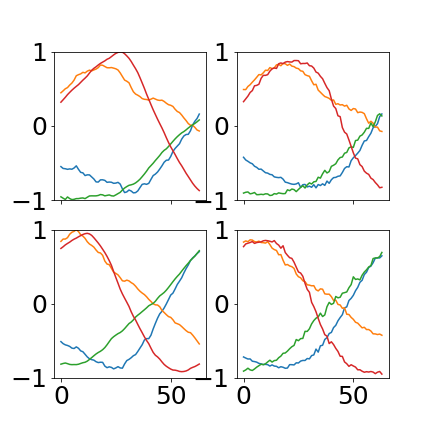

In [24]:
from IPython.display import Image 
Image(filename="./output/train/100.png")